In [1]:
import numpy as np
import pandas as pd
import json as json
from scipy import stats
from statsmodels.formula.api import ols

In [2]:
from o_plot import opl # a small local package dedicated to this project

In [3]:
import sys
print(sys.executable)

C:\Users\decpi\Anaconda3\envs\QK20\python.exe


In [4]:
# loading the data
file_name = 'QAD_data_new.json'
f = open(file_name)
All_data = json.load(f)

## Note for the interpretation of the curves

The quantum state classifier (QSC) rates $\widehat{r}_i$ in function of the number of experimental shots $n$ were determined for each highly entangled quantum state $s_i$. This allowed estimating a safe shot number $n_s$ such that $\forall i\; \widehat{r}_i\le \epsilon$. The value of $\epsilon$ was set at 0.001.

$\widehat{r}_{max}$ is the maximal value observed among all the  $\widehat{r}_i$ values for a given number of shots $n_s$.

The curves seen on the figures represents the mean QSC error rate $\widehat{r}_{mean}$ accross the 20 quantum states in function of $n$. 

# Statistical overview

For this section, an ordinary linear least square estimation is performed.
The dependent variable is the neperian logarithm of $n_s$. 

In [5]:
#defining the pandas data frame for statistics
df_All= pd.DataFrame(All_data,columns=['shots', 'device', 'fidelity',
                                        'mitigation','model','id_gates',
                                        'QV', 'metric'])
# any shot number >= 488 indicates that the curve calculation was ended after reaching n = 500:
df_All.loc[df_All.shots>=488,"shots"]=np.nan
# add the variable neperian log of safe shot number:
df_All['log_shots'] = np.log(df_All['shots']) 

In [6]:
stat_model = ols("log_shots ~  metric + mitigation + model + fidelity + QV + id_gates + device",
                 df_All.query("device != 'ideal_device' ")).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     19.81
Date:                Sun, 20 Dec 2020   Prob (F-statistic):           1.96e-16
Time:                        23:13:42   Log-Likelihood:                -36.155
No. Observations:                  84   AIC:                             92.31
Df Residuals:                      74   BIC:                             116.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

#### Comments:

For the QSC, two different metrics were compared and at the end they gave the same output (see details in appendix 1). For further analysis, the results obtained using the squared euclidean distance between distribution will be illustrated in this notebook, as it is more classical and strictly equivalent to the other classical Hellinger and Bhattacharyya distances. The Jensen-Shannon metric has however the theoretical advantage of being bayesian in nature and therefore presented as an option for the result analysis.

Measurement error mitigation boosted the QSC performance (see details in appendix 2). However, $n_s$ values obtained for experimentally observed count distribution before mitigation are selected here because they anticipate how the method could perform in devices with more qubits where obtaining the mitigation filter is a problem. Mitigation is however presented as an option.

As a whole, a QSC feeded with the front end empirical model significantly outperformed an QSC feeded with the ideal device model.
 
In term of $\ln n_s$ values, the backends are ranked in descending order as follows, the latest being the best performers:

            ibmqx2, ibmq_ourense, ibmq_valencia, ibmq_athens, ibmq_santiago, ibmq_vigo

The quantum measurement fidelity measured at the moment of the experimentations is a significant predictor, but the quantum volume $QV$ is not.

Introducing a delay time $\delta t$ of 256 identity gates between state creation and measurement significantly increased $\ln n_s$ (see details in appendix 3). 


# Detailed statistical analysis



### determine the options

In [7]:
# this for Jensen-Shannon metric 
s_metric = 'jensenshannon'
sm = np.array([96])
SAD=0
# ! will be unselected by running the next cell

In [8]:
# main option for metric: squared euclidean distance
# skip this cell if you don't want this option
s_metric = 'sqeuclidean'
sm = np.array([97])
SAD=2   

In [9]:
# this for measurement mitigation
mit = 'yes'
MIT=0
# ! will be unselected by running the next cell

In [10]:
# main option: no mitigation
# skip this cell if you don't want this option
mit = 'no'
MIT=-4

## 1. Compare distribution models


In [11]:
# select data according to the options
df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]

<ipython-input-11-af347b9ea33a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]


### a look at $n_s$ and at the derived dependent variable $\ln n_s$

In [12]:
print("mitigation:",mit,"  metric:",s_metric )
df_mod.groupby('device')[['shots','log_shots']].describe(percentiles=[0.5])

mitigation: no   metric: sqeuclidean


shots                                          log_shots  \
              count    mean         std    min    50%    max     count   
device                                                                   
ibmq_athens     4.0   43.75   31.063108   22.0   32.0   89.0       4.0   
ibmq_ourense    3.0   67.00   22.516660   41.0   80.0   80.0       3.0   
ibmq_santiago   4.0   36.75   20.532495   23.0   28.5   67.0       4.0   
ibmq_valencia   4.0  102.25  110.837343   35.0   53.0  268.0       4.0   
ibmq_vigo       4.0   36.00   18.036999   22.0   30.0   62.0       4.0   
ibmqx2          1.0  212.00         NaN  212.0  212.0  212.0       1.0   

                                                                 
                   mean       std       min       50%       max  
device                                                           
ibmq_athens    3.615529  0.631676  3.091042  3.441219  4.488636  
ibmq_ourense   4.159208  0.385932  3.713572  4.382027  4.382027  
ibmq_santiago  3.506200  0.486315  3.135494  3.342306  4.204693  
ibmq_valencia  4.271373  0.901680  3.555348  3.969579  5.590987  
ibmq_vigo      3.500658  0.454516  3.091042  3.392229  4.127134  
ibmqx2         5.356586       NaN  5.356586  5.356586  5.356586

### Ideal vs empirical model: no state creation - measurements delay

<Figure size 432x288 with 0 Axes>

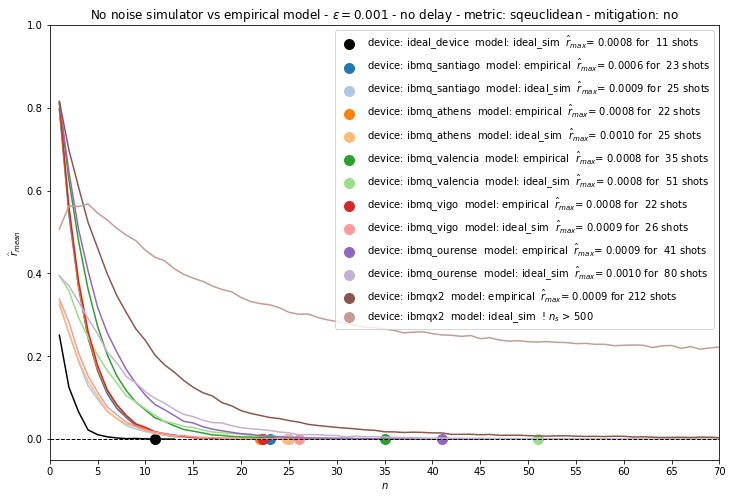

In [13]:
ADD=0+SAD+MIT
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,44,45])),                                                      
            "No noise simulator vs empirical model - $\epsilon=0.001$ - no delay",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 70)

In [14]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  model + fidelity ", df_mod.query("id_gates == 0.0 ")).fit()
print(stat_model.summary())

mitigation: no   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     73.46
Date:                Sun, 20 Dec 2020   Prob (F-statistic):           7.11e-06
Time:                        23:13:44   Log-Likelihood:                 5.0802
No. Observations:                  11   AIC:                            -4.160
Df Residuals:                       8   BIC:                            -2.967
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Ideal vs empirical model: with state creation - measurements delay of 256  id gates

<Figure size 432x288 with 0 Axes>

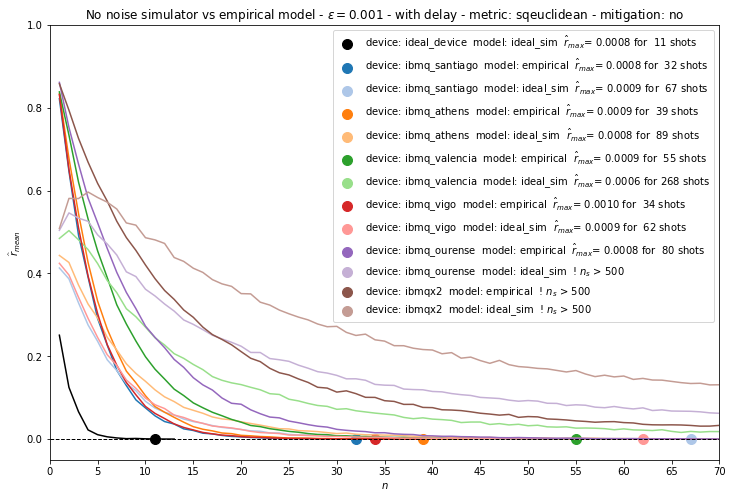

In [15]:
ADD=48+SAD+MIT
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,44,45])),                                                      
            "No noise simulator vs empirical model - $\epsilon=0.001$ - with delay",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 70)

In [16]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  model + fidelity", df_mod.query("id_gates == 256.0")).fit() 
print(stat_model.summary())

mitigation: no   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     19.49
Date:                Sun, 20 Dec 2020   Prob (F-statistic):            0.00237
Time:                        23:13:45   Log-Likelihood:                0.72739
No. Observations:                   9   AIC:                             4.545
Df Residuals:                       6   BIC:                             5.137
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Pooling results obtained in circuit sets with and without creation-measurement delay

In [17]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  model + fidelity + id_gates",
                 df_mod).fit() 
print(stat_model.summary())

mitigation: no   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     36.00
Date:                Sun, 20 Dec 2020   Prob (F-statistic):           2.41e-07
Time:                        23:13:45   Log-Likelihood:               -0.66835
No. Observations:                  20   AIC:                             9.337
Df Residuals:                      16   BIC:                             13.32
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

#### Comments:
This analysis confirms that front end empirical model significantly outperformed an oracle feeded with the ideal device model wheter or not $\delta t$ is introduced.

##  2. Error rate vs quantum readout fidelity and quantum volume

### 2.1 correlation between $\ln \; n_s$ for $\epsilon$ = 0.001 and  quantum readout error fidelity

<Figure size 720x432 with 0 Axes>

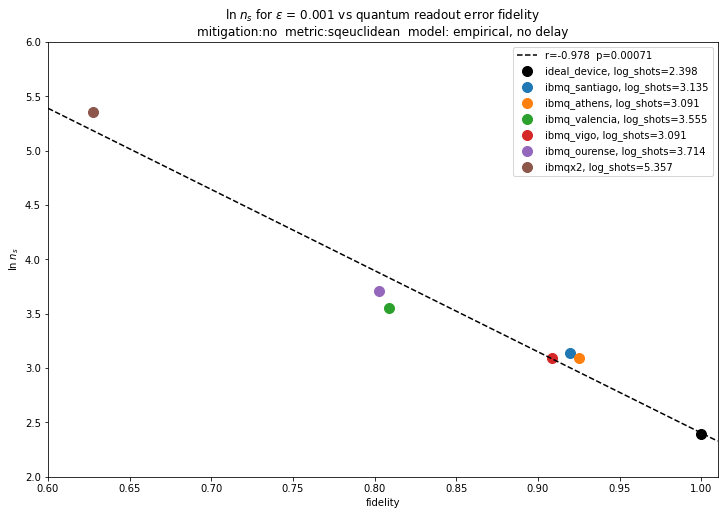

In [18]:
# rem: in this figure, the ideal device calculated value is shown
# but not included in the regression model
df_short = df_All.query("model == 'empirical' & id_gates == 0.0")
df_short = df_short[df_short.metric == s_metric]
# here for adding the "ideal device" observation (11 shots for fidelity = 1.0)
df_ideal= df_All.query("device == 'ideal_device' ")
df_ideal = df_ideal[df_ideal.metric == s_metric]  
df_short = df_short[df_short['mitigation']==mit]
tit_head = "$\ln \; n_s$ for $\epsilon$ = 0.001 vs "
tit_tail =  "mitigation:"+mit+ "  metric:"+s_metric+"  model: empirical, no delay"
opl.plot_scatter(df_ideal.append(df_short),"fidelity",
     tit_head + "quantum readout error fidelity\n" +tit_tail,
     left_xlimit = 0.6, right_xlimit = 1.01,
     bottom_ylimit = 2, top_ylimit = 6)

In [19]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  fidelity",
                 df_mod.query("id_gates == 0.0 & model == 'empirical'")).fit() 
print(stat_model.summary())

mitigation: no   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     88.54
Date:                Sun, 20 Dec 2020   Prob (F-statistic):           0.000711
Time:                        23:13:46   Log-Likelihood:                 2.2689
No. Observations:                   6   AIC:                           -0.5379
Df Residuals:                       4   BIC:                           -0.9544
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [20]:
# check if python linregress (figure) and OLS stat_model (table) agree
round(np.sqrt(stat_model.rsquared),3)

0.978

In [21]:
# calculate the expected value of n_s for a theoretical fidelity equal to 1.0
# to be compared to the oracle derived value for an ideal device: n_s = 11  
alpha, beta = stat_model.params
n_ideal = np.exp(alpha+beta)
n_ideal

11.058238680385552

<Figure size 432x288 with 0 Axes>

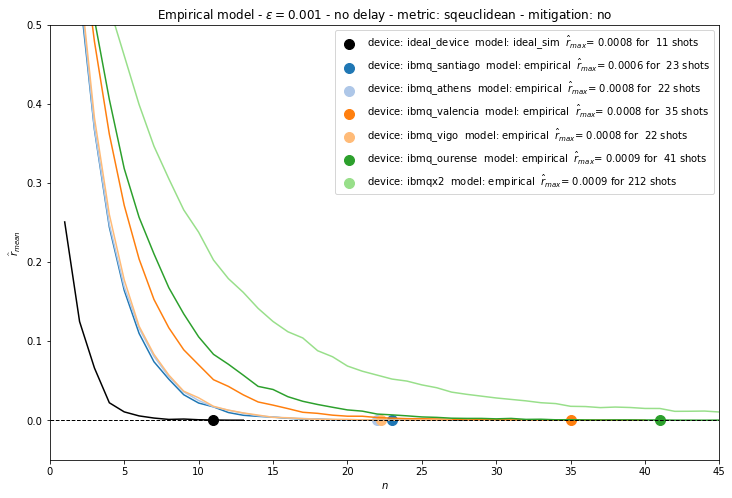

In [22]:
ADD=0+SAD+MIT
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,12,20,28,36,44])),                                                      
            "Empirical model - $\epsilon=0.001$ - no delay",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 45, top_ylimit = 0.5)

#### Comments:

A significant correlation was found between the safe shot number $\ln \; n_s$ and the quantum readout error fidelity measured at the experimental moment.

The graph here concerns the strongest correlation, which was observed in the case of the experimental model and no delay between state creation and measurement.

The correlation is weaker, albeit significant, when mitigation is used:

    r=0.978, p<0.0001 without mitigation vs. r=0.938, p<0.01 with mitigation
    
Interestingly, when no mitigation is applied, the $n_s$ value of 11 for an ideal device assessed independently by the QSC and the $n_s$ value of 11.06 derived from the regression predictors for a fidelity of 1 are quiet similar .


### 2.2 correlation between $\ln \; n_s$ for $\epsilon$ = 0.001 and  quantum volume

<Figure size 720x432 with 0 Axes>

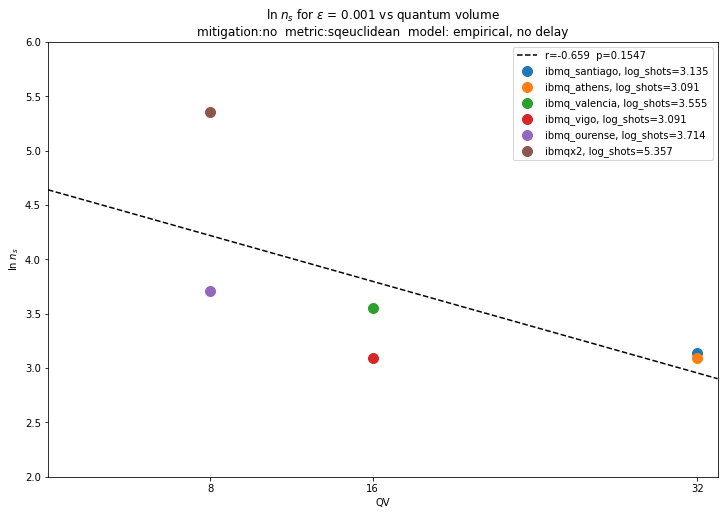

In [23]:
opl.plot_scatter(df_short, "QV",
     tit_head + "quantum volume\n" + tit_tail,
     left_xlimit = 0, right_xlimit = 33,
     bottom_ylimit = 2, top_ylimit = 6)

In [24]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  QV",
                 df_mod.query("id_gates == 0.0 & model == 'empirical'")).fit() 
print(stat_model.summary())

mitigation: no   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     3.069
Date:                Sun, 20 Dec 2020   Prob (F-statistic):              0.155
Time:                        23:13:47   Log-Likelihood:                -5.4468
No. Observations:                   6   AIC:                             14.89
Df Residuals:                       4   BIC:                             14.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [25]:
# # check if python linregress (figure) and OLS stat_model (table) agree
round(np.sqrt(stat_model.rsquared),3)

0.659

#### Comments:

Note that as a whole (see above statistical overview) and in subgroups no significant correlation could be statistically asserted between $n_s$ and the published device quantum volume $QV$. The present figure shows the correlation obtained in the best possible setting.